In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def vis_model(model, show_shapes=False, show_layer_names=True, rankdir='TB'):
    return SVG(
        model_to_dot(
            model,
            show_shapes=show_shapes, show_layer_names=show_layer_names, rankdir=rankdir
        ).create(prog='dot', format='svg')
    )

Using TensorFlow backend.


In [3]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from kerashistoryplot.callbacks import PlotHistory

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [4]:
from sklearn.model_selection import train_test_split

In [352]:
def make_data(num=1000, sort=True):
    x = np.linspace(0, 1, num=num)
    scale = x
    mean = 4 * x * ( 1 - x )
    y = mean + np.random.exponential(scale=scale, size=x.size)
    return x.reshape(-1, 1), y

X_train, y_train = make_data(num=10000)
X_test, y_test = make_data(num=1000)

X_plot = np.linspace(min(X_train), max(X_train), num=200).reshape(-1, 1)

In [353]:
quantiles = [0.001, 0.01, 0.25, 0.5, 0.75, 0.99, 0.999]
q_theor = np.hstack([
    -np.log(1 - q) * X_test + 4 * X_test * ( 1 - X_test )
    for q in quantiles
])

In [354]:
mean_theor = 4 * X_test * ( 1 - X_test ) + X_test

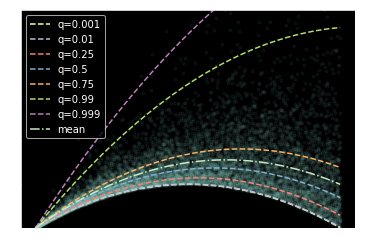

In [355]:
plt.plot(X_train, y_train, '.', alpha=0.05)
for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'q={q}')
plt.plot(X_test, mean_theor, '-.', label='mean')
plt.ylim(0, 5)
plt.legend()

In [356]:
import deepquantiles

from deepquantiles.losses import sk_quantile_loss

In [357]:
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_delta=0.01),
    EarlyStopping(monitor='loss', patience=15),
    PlotHistory(batches=False, n_cols=3, figsize=(15, 7))
]

# Individual Quantiles

In [605]:
regressor = deepquantiles.MultiQuantileRegressor(
    shared_units=(),
    quantile_units=(32, 32, 32, 32, ),
    quantiles=quantiles,
    lr=0.01,
    epochs=100,
    batch_size=1000
)

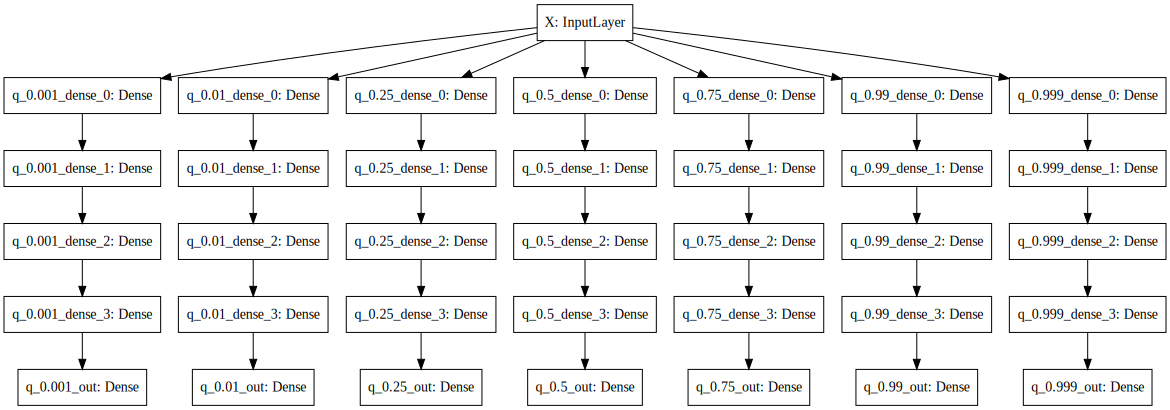

In [606]:
vis_model(regressor.model, show_shapes=False)

In [607]:
regressor.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
q_0.001_dense_0 (Dense)         (None, 32)           64          X[0][0]                          
__________________________________________________________________________________________________
q_0.01_dense_0 (Dense)          (None, 32)           64          X[0][0]                          
__________________________________________________________________________________________________
q_0.25_dense_0 (Dense)          (None, 32)           64          X[0][0]                          
__________________________________________________________________________________________________
q_0.5_dens

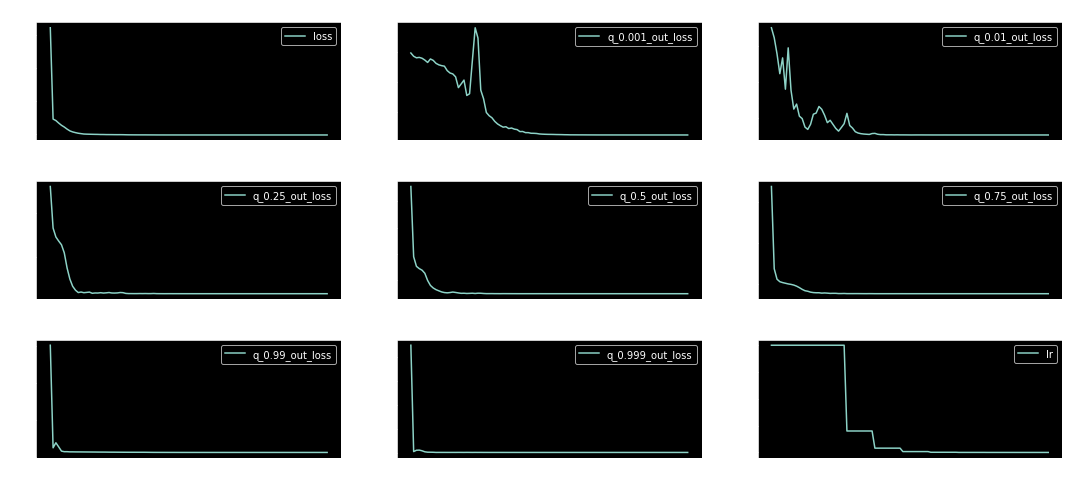

CPU times: user 4min 34s, sys: 30.3 s, total: 5min 4s
Wall time: 2min 29s


In [608]:
%%time
regressor.fit(X_train, y_train, verbose=1, callbacks=callbacks, shuffle=True)

In [609]:
q_preds = regressor.predict(X_test)

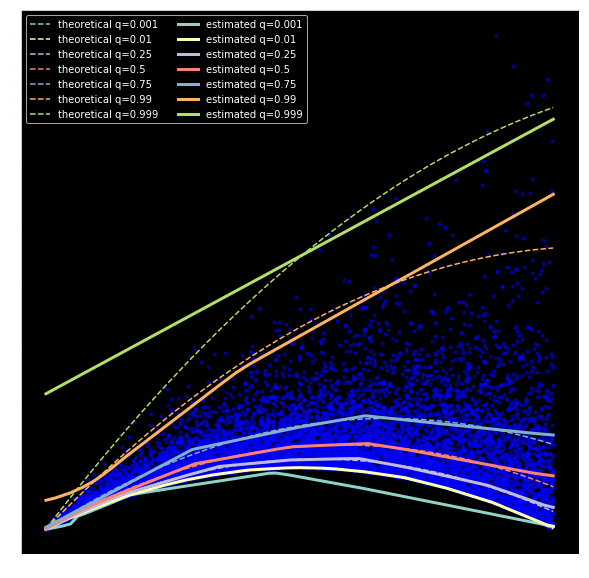

In [610]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds.T):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

In [611]:
%%time
scores = [sk_quantile_loss(q, y_test, q_pred) for q, q_pred in zip(quantiles, q_preds.T)]

CPU times: user 1.12 ms, sys: 619 µs, total: 1.74 ms
Wall time: 979 µs


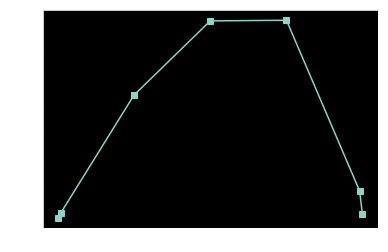

In [612]:
plt.plot(regressor.quantiles, scores, 's-')

# Multi-Quantile Regression

In [236]:
regressor = deepquantiles.MultiQuantileRegressor(
    shared_units=(32, 32, 32),
    quantile_units=(32, ),
    quantiles=quantiles,
    lr=0.01,
    epochs=100,
    batch_size=1000
)

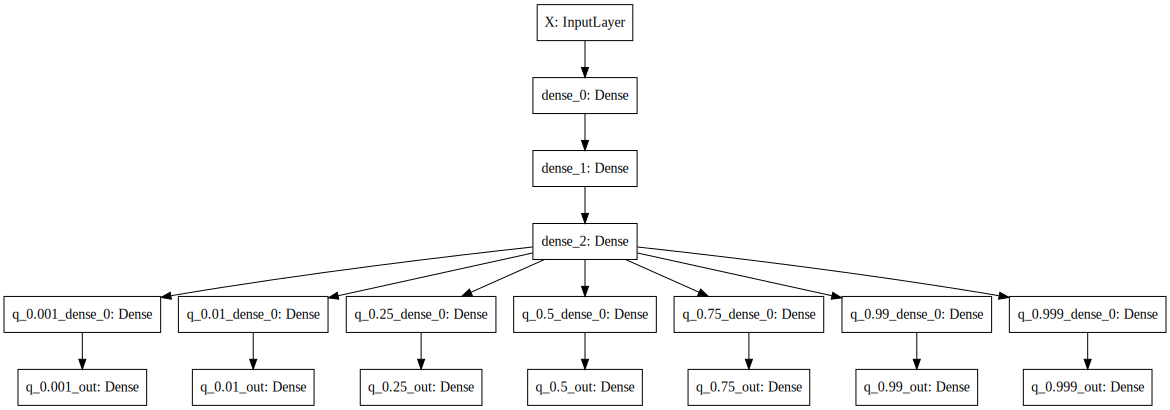

In [237]:
vis_model(regressor.model, show_shapes=False)

In [238]:
regressor.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
dense_0 (Dense)                 (None, 32)           64          X[0][0]                          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        dense_0[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           1056        dense_1[0][0]                    
__________________________________________________________________________________________________
q_0.001_de

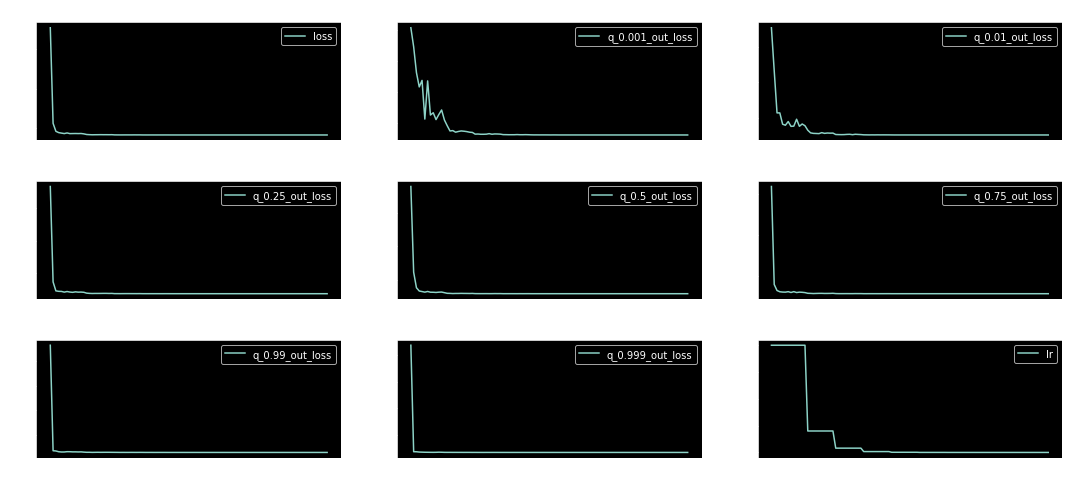

CPU times: user 5min 52s, sys: 51.5 s, total: 6min 43s
Wall time: 3min 12s


In [239]:
%%time
regressor.fit(X_train, y_train, verbose=1, callbacks=callbacks, shuffle=True)

In [240]:
q_preds = regressor.predict(X_test)

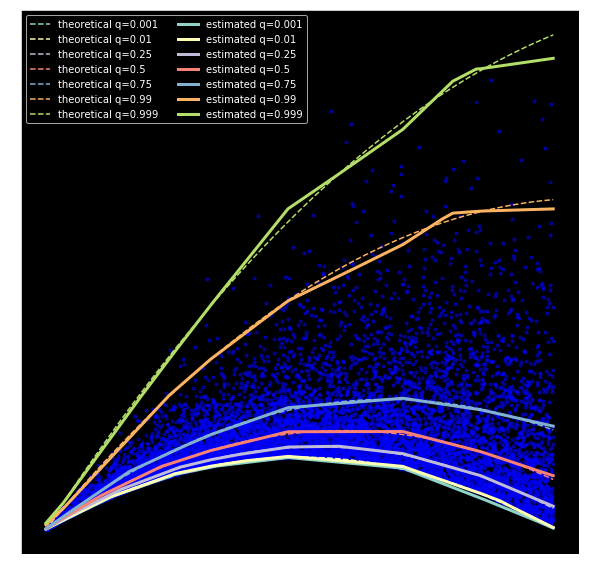

In [241]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds.T):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

In [242]:
%%time
scores = [sk_quantile_loss(q, y_test, q_pred) for q, q_pred in zip(quantiles, q_preds.T)]

CPU times: user 797 µs, sys: 336 µs, total: 1.13 ms
Wall time: 777 µs


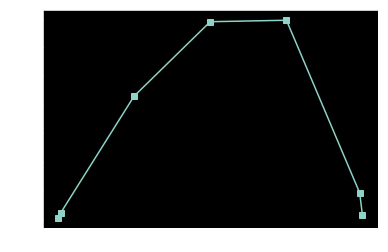

In [243]:
plt.plot(regressor.quantiles, scores, 's-')

In [249]:
%%time
print(X_test.shape)
samples = regressor.sample(X_test, num_samples=10000)
print(samples.shape)

(10000, 1)
(10000, 10000)
CPU times: user 3.64 s, sys: 709 ms, total: 4.35 s
Wall time: 4.22 s


In [250]:
mean_pred = samples.mean(axis=1)

In [251]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(mean_theor, mean_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(mean_theor, mean_pred)
print(rmse, mae)

0.11004811720068715 0.09403060467399214


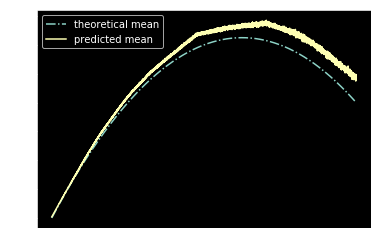

In [252]:
#plt.figure(figsize=(10, 10))
#plt.plot(X_test, y_test, 'b.', alpha=0.5)
plt.plot(X_test, mean_theor, '-.', label='theoretical mean')
plt.plot(X_test, mean_pred, label='predicted mean')
plt.legend()

## Regress on Quantile `q`

In [433]:
regressor = deepquantiles.CDFRegressor(
    feature_units=(32, 32, 32),
    quantile_units=(),
    shared_units=(32,),
    activation='relu',
    batch_norm=True,
    lr=0.01,
    epochs=100,
    batch_size=10000,
    q_mode='const',
    shuffle_points=True,
)

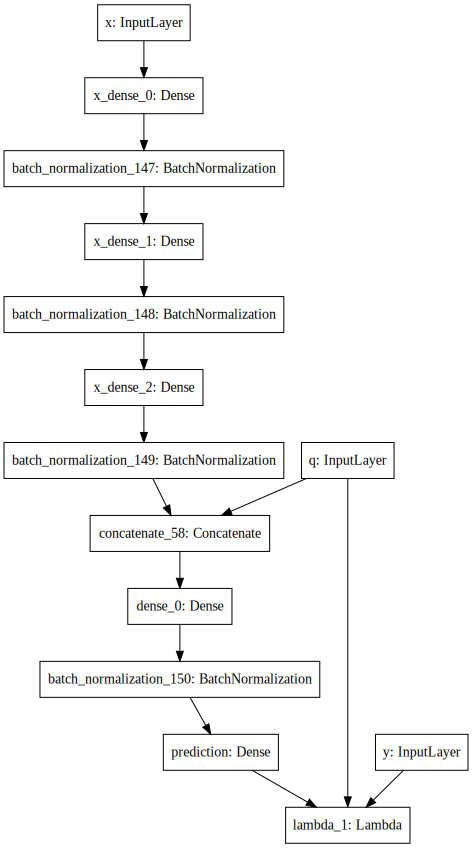

In [434]:
vis_model(regressor.model['loss'])

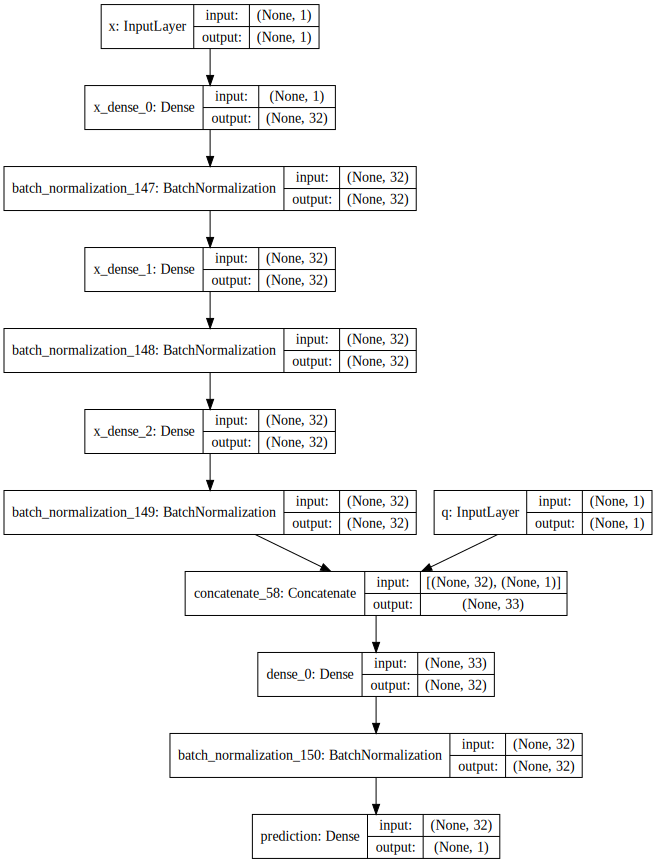

In [435]:
vis_model(regressor.model['quantile'], show_shapes=True)

In [436]:
regressor.model['quantile'].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
x_dense_0 (Dense)               (None, 32)           64          x[0][0]                          
__________________________________________________________________________________________________
batch_normalization_147 (BatchN (None, 32)           128         x_dense_0[0][0]                  
__________________________________________________________________________________________________
x_dense_1 (Dense)               (None, 32)           1056        batch_normalization_147[0][0]    
__________________________________________________________________________________________________
batch_norm

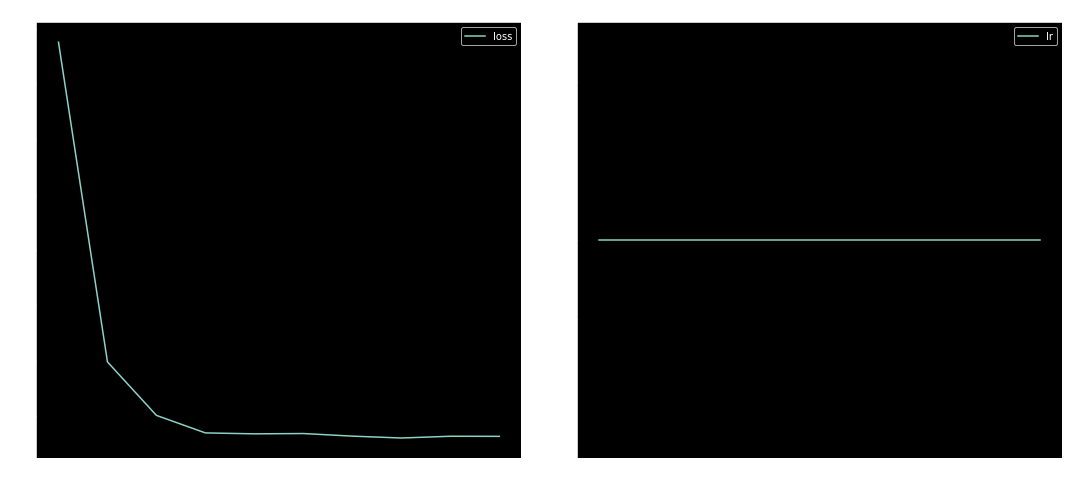

CPU times: user 23.3 s, sys: 2.14 s, total: 25.4 s
Wall time: 17.5 s


In [437]:
%%time
regressor.fit(X_train, y_train, verbose=1, callbacks=callbacks, epochs=10, batch_size=1000, q_mode='point')

In [443]:
%%time
q_preds = regressor.predict(X_test, quantiles=quantiles)

CPU times: user 34.2 ms, sys: 5.03 ms, total: 39.2 ms
Wall time: 13 ms


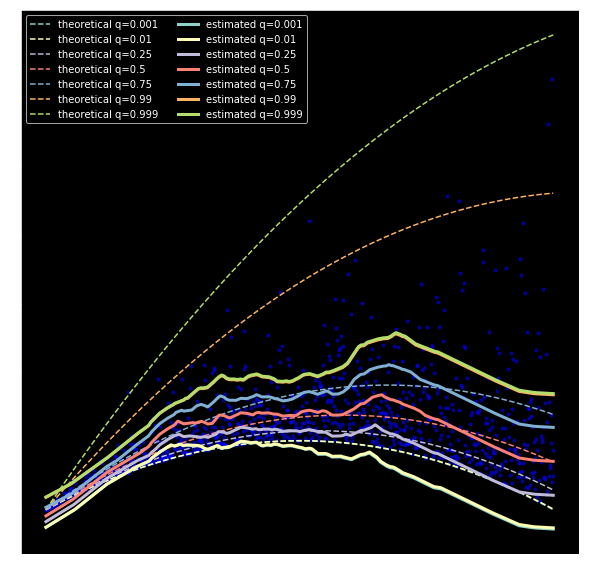

In [445]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds.T):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

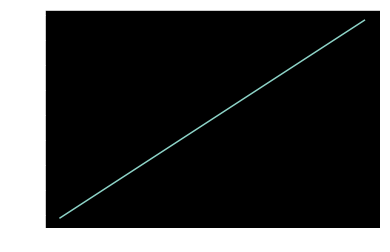

In [446]:
num = 100
qs = np.linspace(0, 1, num=num)
preds = regressor.model['quantile'].predict([0.99 + 0 * qs, qs])
plt.plot(qs, preds)

In [447]:
%%time
scores = [sk_quantile_loss(q, y_test, q_pred) for q, q_pred in zip(quantiles, q_preds.T)]

CPU times: user 517 µs, sys: 344 µs, total: 861 µs
Wall time: 583 µs


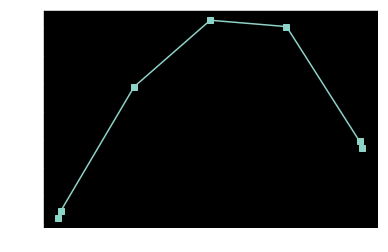

In [448]:
plt.plot(quantiles, scores, 's-')

In [449]:
%%time
print(X_test.shape)
samples = regressor.sample(X_test, num_samples=10000, num_quantiles=10, batch_s)
print(samples.shape)

(1000, 1)
(1000, 10000)
CPU times: user 436 ms, sys: 59.1 ms, total: 496 ms
Wall time: 459 ms


In [412]:
mean_pred = samples.mean(axis=1)

In [413]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(mean_theor, mean_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(mean_theor, mean_pred)
print(rmse, mae)

0.17304238529082341 0.12346939846182062


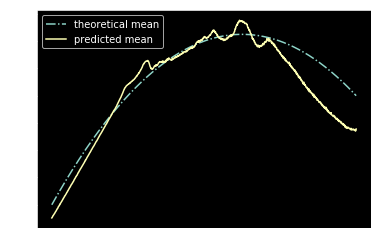

In [414]:
#plt.figure(figsize=(10, 10))
#plt.plot(X_test, y_test, 'b.', alpha=0.5)
plt.plot(X_test, mean_theor, '-.', label='theoretical mean')
plt.plot(X_test, mean_pred, label='predicted mean')
plt.legend()

In [415]:
regressor.gen_.q_mode = 'adaptive'

In [424]:
regressor.batch_size = 1

In [425]:
%%time
regressor.gen_.on_epoch_end()

CPU times: user 10 s, sys: 1 s, total: 11 s
Wall time: 8.57 s


In [417]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [421]:
%lprun -u 1 -f deepquantiles.CDFRegressor.predict regressor.gen_.on_epoch_end()

Timer unit: 1 s

Total time: 31.884 s
File: /Users/igor/checkouts/igor/deepquantiles/deepquantiles/cdf.py
Function: predict at line 156

Line #      Hits         Time  Per Hit   % Time  Line Contents
   156                                               def predict(self, X, quantiles=None, **kwargs):
   157         2          0.0      0.0      0.0          fit_kwargs = dict(
   158         2          0.0      0.0      0.0              batch_size=self.batch_size,
   159                                                   )
   160         2          0.0      0.0      0.0          fit_kwargs.update(kwargs)
   161                                           
   162         2          0.0      0.0      0.0          if quantiles is None:
   163                                                       quantiles = self.quantiles
   164         2          0.0      0.0      0.0          X_tiled = np.repeat(X, len(quantiles), axis=1).reshape(-1, 1)
   165         2          0.0      0.0      0.0         

In [400]:
np.repeat([[1], [2], [3]], 3, axis=1).reshape(-1, 1)

array([[1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3]])

In [404]:
np.tile([0, 0.5, 1], 2)

array([0. , 0.5, 1. , 0. , 0.5, 1. ])

## Gradient Boosting QR

In [359]:
from sklearn.ensemble import GradientBoostingRegressor

In [420]:
gbr = GradientBoostingRegressor(
    loss='quantile',
    n_estimators=250,
    max_depth=1,
    learning_rate=.1,
)

In [421]:
%%time
quantiles = quantiles
q_preds = []
scores = []
for q in quantiles:
    gbr.set_params(alpha=q)
    gbr.fit(X_train, y_train)
    q_pred = gbr.predict(X_test)
    q_preds.append(q_pred)
    scores.append(sk_quantile_loss(q, y_test, q_pred))

CPU times: user 2.91 s, sys: 10.1 ms, total: 2.92 s
Wall time: 2.94 s


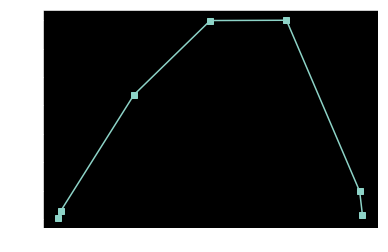

In [422]:
plt.plot(quantiles, scores, 's-')

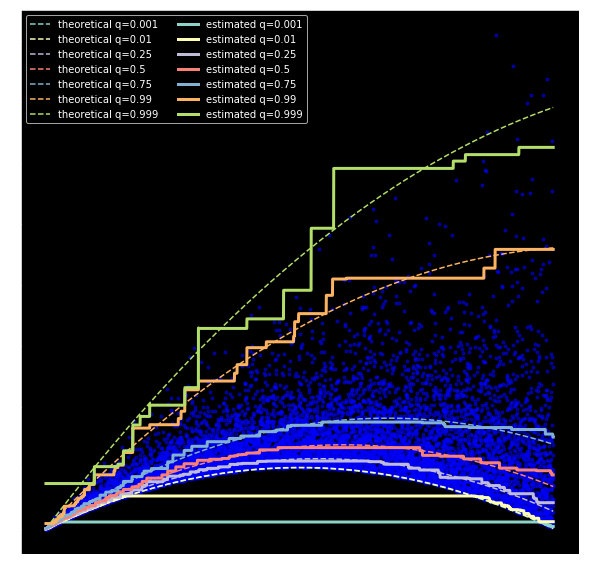

In [423]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

## CatBoost

In [250]:
from catboost import CatBoostRegressor
from tqdm.autonotebook import tqdm

In [251]:
cbr = CatBoostRegressor(verbose=0)

In [252]:
quantiles = quantiles
q_preds = []
scores = []
for q in tqdm(quantiles):
    cbr.set_params(loss_function=f'Quantile:alpha={q}')
    cbr.fit(X_train, y_train)
    q_pred = cbr.predict(X_test)
    q_preds.append(q_pred)
    scores.append(sk_quantile_loss(q, y_test, q_pred))

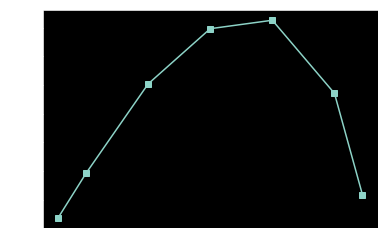

In [253]:
plt.plot(quantiles, scores, 's-')

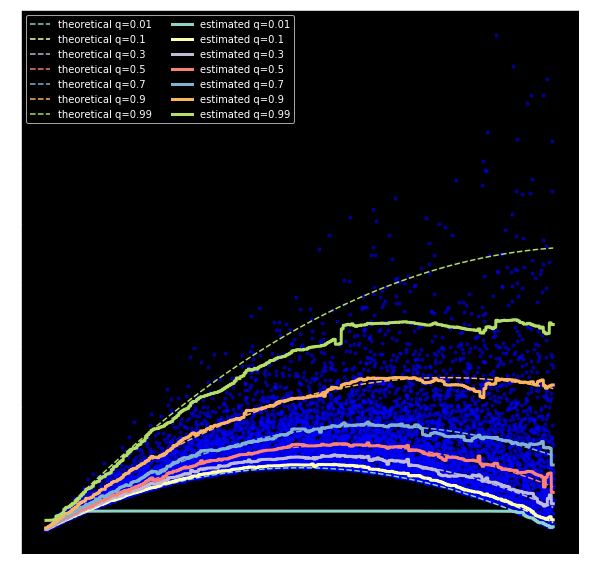

In [256]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)